In [1]:
import os
import glob
import math
import obspy
import time
from obspy.clients.iris import Client
client = Client()
from matplotlib import pyplot as plt, patches
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import clear_output
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [2]:
ddir = "/home/ketan/IndiaConnectNTU/Week 6-10/QuantMeasure"
data_sac = f"{ddir}/Download/SAC"
wdir = f"{ddir}/Download/Verified"

if not os.path.exists(wdir):
    os.mkdir(wdir)

In [3]:
def set_window(st, Tp1, Tp, TsPmP, TsPn, Twbefore=3, Twafter=2, error_k = 0, Tpbefore=0.3, Tplen=0.6, Tspmbefore=0.3, Tspmlen=0.6, Tspnbefore=0.3, Tspnlen=0.6):
    '''
    set the proper time window to verify sP depth phase.
    st -- data streams
    Twbefore -- time before P-wave
    Twafter -- time after P-wave
    Txbefore -- time before x phase
    Txlen -- window length for x phase
    '''
    t = np.arange(st[0].stats.sac.t1-Twbefore, st[0].stats.sac.t1+(max(TsPmP,TsPn)-2*Tp1+Tp+Twafter)-error_k/100, st[0].stats.delta)
    idxw1 = int((st[0].stats.sac.t1-Twbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxw2 = int((st[0].stats.sac.t1+(max(TsPmP,TsPn)-2*Tp1+Tp+Twafter)-st[0].stats.sac.b)/st[0].stats.delta)
    idxp1 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxp2 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore+Tplen-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm1 = int((st[0].stats.sac.t1+TsPmP-2*Tp1+Tp-Tspmbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm2 = int((st[0].stats.sac.t1+TsPmP-2*Tp1+Tp-Tspmbefore+Tspmlen-st[0].stats.sac.b)/st[0].stats.delta)
    fig = plt.figure(figsize=(20,8))

    ax1 = fig.add_subplot(311)
    ax1.plot(t,st[2].data[idxw1:idxw2],color="black",label="Z-Component")
    plt.xticks(np.arange(t[0], t[-1]+0.1, 0.5))
    ax1.axvline(x=st[2].stats.sac.t1, color="red", alpha=0.8, linewidth=2,label="Predicted")
    ax1.axvline(x=Tp-Tp1, color="blue", alpha=0.8, linewidth=2,label="Refined")
    hei = max(abs(st[2].data[idxp1:idxp2]))
    rect = patches.Rectangle((Tp-Tp1-Tpbefore, -1.8*hei), Tplen, 3.6*hei, color='blue',alpha=0.25)
    ax1.add_patch(rect)
    ax1.axvline(x=TsPmP-2*Tp1+Tp, color="green", alpha=0.8, linewidth=2, label="sPmP refined")
    hei = max(abs(st[2].data[idxspm1:idxspm2]))
    rect = patches.Rectangle((TsPmP-2*Tp1+Tp-Tspmbefore, -1.8*hei), Tspmlen, 3.6*hei, color='green',alpha=0.25)
    ax1.add_patch(rect)
    if str(TsPn) != "nan":
        ax1.axvline(x=TsPn-2*Tp1+Tp, color="cyan", alpha=0.8, linewidth=2, label="sPn refined")
        idxspn1 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)
        hei = max(abs(st[2].data[idxspn1:idxspn2]))
        rect = patches.Rectangle((TsPn-2*Tp1+Tp-Tspnbefore, -1.8*hei), Tspnlen, 3.6*hei, color='cyan',alpha=0.25)
        ax1.add_patch(rect)
    ax1.legend(loc="upper left")
    ax1.set_ylabel("Amplitude",fontsize=15)
    ax1.grid()

    ax2 = fig.add_subplot(312)
    ax2.plot(t,st[0].data[idxw1:idxw2],color="black",label="R-Component")
    plt.xticks(np.arange(t[0], t[-1]+0.1, 0.5))
    ax2.axvline(x=Tp-Tp1, color="blue", alpha=0.8, linewidth=2)
    hei = max(abs(st[0].data[idxp1:idxp2]))
    rect = patches.Rectangle((Tp-Tp1-Tpbefore, -1.8*hei), Tplen, 3.6*hei, color='blue',alpha=0.25)
    ax2.add_patch(rect)
    ax2.axvline(x=TsPmP-2*Tp1+Tp, color="green", alpha=0.8, linewidth=2)
    hei = max(abs(st[0].data[idxspm1:idxspm2]))
    rect = patches.Rectangle((TsPmP-2*Tp1+Tp-Tspmbefore, -1.8*hei), Tspmlen, 3.6*hei, color='green',alpha=0.25)
    ax2.add_patch(rect)
    if str(TsPn) != "nan":
        ax2.axvline(x=TsPn-2*Tp1+Tp, color="cyan", alpha=0.8, linewidth=2)
        idxspn1 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)
        hei = max(abs(st[0].data[idxspn1:idxspn2]))
        rect = patches.Rectangle((TsPn-2*Tp1+Tp-Tspnbefore, -1.8*hei), Tspnlen, 3.6*hei, color='cyan',alpha=0.25)
        ax2.add_patch(rect)
    ax2.legend(loc="upper left")
    ax2.set_ylabel("Amplitude",fontsize=15)
    ax2.grid()

    ax3 = fig.add_subplot(313)
    ax3.plot(t,st[1].data[idxw1:idxw2],color="black",label="T-Component")
    plt.xticks(np.arange(t[0], t[-1]+0.1, 0.5))
    ax3.axvline(x=Tp-Tp1, color="blue", alpha=0.8, linewidth=2)
    hei = max(abs(st[1].data[idxp1:idxp2]))
    rect = patches.Rectangle((Tp-Tp1-Tpbefore, -1.8*hei), Tplen, 3.6*hei, color='blue',alpha=0.25)
    ax3.add_patch(rect)
    ax3.axvline(x=TsPmP-2*Tp1+Tp, color="green", alpha=0.8, linewidth=2)
    hei = max(abs(st[1].data[idxspm1:idxspm2]))
    rect = patches.Rectangle((TsPmP-2*Tp1+Tp-Tspmbefore, -1.8*hei), Tspmlen, 3.6*hei, color='green',alpha=0.25)
    ax3.add_patch(rect)
    if str(TsPn) != "nan":
        ax3.axvline(x=TsPn-2*Tp1+Tp, color="cyan", alpha=0.8, linewidth=2)
        idxspn1 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)
        hei = max(abs(st[1].data[idxspn1:idxspn2]))
        rect = patches.Rectangle((TsPn-2*Tp1+Tp-Tspnbefore, -1.8*hei), Tspnlen, 3.6*hei, color='cyan',alpha=0.25)
        ax3.add_patch(rect)
    ax3.legend(loc="upper left")
    ax3.set_xlabel("Time (s)",fontsize=15)
    ax3.set_ylabel("Amplitude",fontsize=15)
    ax3.grid()

    fig.suptitle(f'Set Up Time Window\n(Pbefore:{Tpbefore}s, Plen:{Tplen}s, sPmPbefore:{Tspmbefore}s, sPmPlen:{Tspmlen}s, sPnbefore:{Tspnbefore}s, sPnlen:{Tspnlen}s)',fontsize=20)
    plt.show()
    return fig

In [4]:
def func(pct, allvals):
    absolute = pct*np.sum(allvals)
    return "{:.1f}%\n({:.2e})".format(pct, absolute)

def vef_amp(st, Tp1, Tp, TsPmP, TsPn, Tpbefore=0.3, Tplen=0.6, Tspmbefore=0.3, Tspmlen=0.6, Tspnbefore=0.3, Tspnlen=0.6):
    
    idxp1 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxp2 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore+Tplen-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm1 = int((st[0].stats.sac.t1+TsPmP-2*Tp1+Tp-Tspmbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm2 = int((st[0].stats.sac.t1+TsPmP-2*Tp1+Tp-Tspmbefore+Tspmlen-st[0].stats.sac.b)/st[0].stats.delta)

    zamp_p = max(abs(st[2].data[idxp1:idxp2]))
    zrms_p = np.sqrt(np.mean(st[2].data[idxp1:idxp2]**2))
    
    ramp_p = max(abs(st[0].data[idxp1:idxp2]))
    rrms_p = np.sqrt(np.mean(st[0].data[idxp1:idxp2]**2))
    
    tamp_p = max(abs(st[1].data[idxp1:idxp2]))
    trms_p = np.sqrt(np.mean(st[1].data[idxp1:idxp2]**2))
    

    zamp_spm = max(abs(st[2].data[idxspm1:idxspm2]))
    zrms_spm = np.sqrt(np.mean(st[2].data[idxspm1:idxspm2]**2))
    
    ramp_spm = max(abs(st[0].data[idxspm1:idxspm2]))
    rrms_spm = np.sqrt(np.mean(st[0].data[idxspm1:idxspm2]**2))
    
    tamp_spm = max(abs(st[1].data[idxspm1:idxspm2]))
    trms_spm = np.sqrt(np.mean(st[1].data[idxspm1:idxspm2]**2))

    fig = plt.figure(figsize =(18, 9))
    fig.suptitle("Verify Amplitude", fontsize = 20)

    ax1 = fig.add_subplot(231)
    bars = ['Z-P', 'R-P', 'T-P']
    data = [zamp_p, ramp_p, tamp_p]
    ax1.pie(data, labels = bars, autopct = lambda pct: func(pct, data))

    ax2 = fig.add_subplot(232)
    bars = ['Z-sPmP', 'R-sPmP', 'T-sPmP']
    data = [zamp_spm, ramp_spm, tamp_spm]
    ax2.pie(data, labels = bars, autopct = lambda pct: func(pct, data))

    if str(TsPn) != "nan":
        idxspn1 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)

        zamp_spn = max(abs(st[2].data[idxspn1:idxspn2]))
        zrms_spn = np.sqrt(np.mean(st[2].data[idxspn1:idxspn2]**2))
        
        ramp_spn = max(abs(st[0].data[idxspn1:idxspn2]))
        rrms_spn = np.sqrt(np.mean(st[0].data[idxspn1:idxspn2]**2))
        
        tamp_spn = max(abs(st[1].data[idxspn1:idxspn2]))
        trms_spn = np.sqrt(np.mean(st[1].data[idxspn1:idxspn2]**2))

        ax3 = fig.add_subplot(233)
        bars = ['Z-sPn', 'R-sPn', 'T-sPn']
        data = [zamp_spn, ramp_spn, tamp_spn]
        ax3.pie(data, labels = bars, autopct = lambda pct: func(pct, data))
        ratio2 = "{:.1f}".format(zamp_spn/zamp_p)
        ratio2_r = "{:.1f}".format(ramp_spn/ramp_p)
        ratio2_t = "{:.1f}".format(tamp_spn/tamp_p)
        
        ratio2rms = "{:.1f}".format(zrms_spn/zrms_p)
        ratio2rms_r = "{:.1f}".format(rrms_spn/rrms_p)
        ratio2rms_t = "{:.1f}".format(trms_spn/trms_p)

    ratio1 = "{:.1f}".format(zamp_spm/zamp_p)
    ratio1_r = "{:.1f}".format(ramp_spm/ramp_p)
    ratio1_t = "{:.1f}".format(tamp_spm/tamp_p)
    
    ratio1rms = "{:.1f}".format(zrms_spm/zrms_p)
    ratio1rms_r = "{:.1f}".format(rrms_spm/rrms_p)
    ratio1rms_t = "{:.1f}".format(trms_spm/trms_p)
    
    
    if str(TsPn) != "nan":
        ax4 = fig.add_subplot(234)
        ax4.set_title("Max Abs Ratio")
        ax4.text(0.2, 0.8, f'(ZsPmP/ZP={ratio1}, ZsPn/ZP={ratio2})',fontsize=12)
        ax4.text(0.2, 0.6, f'(RsPmP/RP={ratio1_r}, RsPn/RP={ratio2_r})',fontsize=12)
        ax4.text(0.2, 0.4, f'(TsPmP/RP={ratio1_t}, TsPn/RP={ratio2_t})',fontsize=12)
        
        ax5 = fig.add_subplot(235)
        ax5.set_title("RMS Ratio")
        ax5.text(0.2, 0.8, f'(ZsPmP/ZP={ratio1rms}, ZsPn/ZP={ratio2rms})',fontsize=12)
        ax5.text(0.2, 0.6, f'(RsPmP/RP={ratio1rms_r}, RsPn/RP={ratio2rms_r})',fontsize=12)
        ax5.text(0.2, 0.4, f'(TsPmP/RP={ratio1rms_t}, TsPn/RP={ratio2rms_t})',fontsize=12)
        
    else:
        ax4 = fig.add_subplot(234)
        ax4.set_title("Max Abs Ratio")
        ax4.text(0.2, 0.8, f'(ZsPmP/ZP={ratio1}',fontsize=12)
        ax4.text(0.2, 0.6, f'(RsPmP/RP={ratio1_r}',fontsize=12)
        ax4.text(0.2, 0.4, f'(TsPmP/TP={ratio1_t}',fontsize=12)
        
        ax5 = fig.add_subplot(235)
        ax5.set_title("RMS Ratio")
        ax4.text(0.2, 0.8, f'(ZsPmP/ZP={ratio1rms}',fontsize=12)
        ax4.text(0.2, 0.6, f'(RsPmP/RP={ratio1rms_r}',fontsize=12)
        ax4.text(0.2, 0.4, f'(TsPmP/TP={ratio1rms_t}',fontsize=12)
        
    
    plt.show()
    return fig


In [5]:
def vef_polaz(st, Tp1, Tp, TsPmP, TsPn, Tpbefore=0.3, Tplen=0.6, Tspmbefore=0.3, Tspmlen=0.6, Tspnbefore=0.3, Tspnlen=0.6):
    
    idxp1 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxp2 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore+Tplen-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm1 = int((st[0].stats.sac.t1+TsPmP-2*Tp1+Tp-Tspmbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm2 = int((st[0].stats.sac.t1+TsPmP-2*Tp1+Tp-Tspmbefore+Tspmlen-st[0].stats.sac.b)/st[0].stats.delta)

    maxp = max(max(abs(st[2].data[idxp1:idxp2])),max(abs(st[0].data[idxp1:idxp2])),max(abs(st[1].data[idxp1:idxp2])))
    z_p = st[2].data[idxp1:idxp2]/maxp
    r_p = st[0].data[idxp1:idxp2]/maxp
    t_p = st[1].data[idxp1:idxp2]/maxp

    maxspm = max(max(abs(st[2].data[idxspm1:idxspm2])),max(abs(st[0].data[idxspm1:idxspm2])),max(abs(st[1].data[idxspm1:idxspm2])))
    z_spm = st[2].data[idxspm1:idxspm2]/maxspm
    r_spm = st[0].data[idxspm1:idxspm2]/maxspm
    t_spm = st[1].data[idxspm1:idxspm2]/maxspm

    fig = plt.figure(figsize =(12, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(331)
    ax1.axis('equal')
    ax1.plot(z_p, r_p, color="black", label="P")
    
    X = np.column_stack((z_p, r_p))
    pca = PCA(n_components=1)
    pca.fit(X)
    angle = math.degrees(math.atan(pca.components_[0][1]/pca.components_[0][0]))
    ax1.quiver(0,0,pca.components_[0][0],pca.components_[0][1],angles=angle, scale=0.5, pivot="middle", headwidth=0, width=0.03, alpha=0.8, color="red")
    #print(pca.components_)
    if angle < 0:
        angle1 = "{:.0f}".format(180+angle)
    else:
        angle1 = "{:.0f}".format(angle)

    ax1.set_xlabel("Z",fontsize=15)
    ax1.set_ylabel("R",fontsize=15)
    ax1.set_xlim(-1,1)
    ax1.set_ylim(-1,1)
    ax1.grid()
    ax1.tick_params(top=True, bottom=False)
    ax1.tick_params(labeltop=True, labelbottom=False)
    ax1.legend(loc="upper left")

    ax2 = fig.add_subplot(332)
    ax2.axis('equal')
    ax2.plot(z_p, t_p, color="black", label="P")
    ax2.set_xlabel("Z",fontsize=15)
    ax2.set_ylabel("T",fontsize=15)
    ax2.set_xlim(-1,1)
    ax2.set_ylim(-1,1)
    ax2.grid()
    ax2.set_yticklabels([])
    ax2.tick_params(top=True, bottom=False)
    ax2.tick_params(labeltop=True, labelbottom=False)
    ax2.legend(loc="upper left")

    ax3 = fig.add_subplot(333)
    ax3.axis('equal')
    ax3.plot(r_p, t_p, color="black", label="P")
    ax3.set_xlabel("R",fontsize=15)
    ax3.set_ylabel("T",fontsize=15)
    ax3.set_xlim(-1,1)
    ax3.set_ylim(-1,1)
    ax3.grid()
    ax3.set_yticklabels([])
    ax3.tick_params(top=True, bottom=False)
    ax3.tick_params(labeltop=True, labelbottom=False)
    ax3.legend(loc="upper left")

    ax4 = fig.add_subplot(334)
    ax4.axis('equal')
    ax4.plot(z_spm, r_spm, color="black", label="sPmP")

    X = np.column_stack((z_spm, r_spm))
    pca = PCA(n_components=1)
    pca.fit(X)
    angle = math.degrees(math.atan(pca.components_[0][1]/pca.components_[0][0]))
    ax4.quiver(0,0,pca.components_[0][0],pca.components_[0][1],angles=angle, scale=0.5, pivot="middle", headwidth=0, width=0.03, alpha=0.8, color="red")
    if angle < 0:
        angle2 = "{:.0f}".format(180+angle)
    else:
        angle2 = "{:.0f}".format(angle)

    ax4.set_xlabel("Z",fontsize=15)
    ax4.set_ylabel("R",fontsize=15)
    ax4.set_xlim(-1,1)
    ax4.set_ylim(-1,1)
    ax4.grid()
    ax4.set_xticklabels([])
    ax4.legend(loc="upper left")

    ax5 = fig.add_subplot(335)
    ax5.axis('equal')
    ax5.plot(z_spm, t_spm, color="black", label="sPmP")
    ax5.set_xlabel("Z",fontsize=15)
    ax5.set_ylabel("T",fontsize=15)
    ax5.set_xlim(-1,1)
    ax5.set_ylim(-1,1)
    ax5.grid()
    ax5.set_yticklabels([])
    ax5.set_xticklabels([])
    ax5.legend(loc="upper left")

    ax6 = fig.add_subplot(336)
    ax6.axis('equal')
    ax6.plot(r_spm, t_spm, color="black", label="sPmP")
    ax6.set_xlabel("R",fontsize=15)
    ax6.set_ylabel("T",fontsize=15)
    ax6.set_xlim(-1,1)
    ax6.set_ylim(-1,1)
    ax6.grid()
    ax6.set_yticklabels([])
    ax6.set_xticklabels([])
    ax6.legend(loc="upper left")

    if str(TsPn) != "nan":
        idxspn1 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)

        maxspn = max(max(abs(st[2].data[idxspn1:idxspn2])),max(abs(st[0].data[idxspn1:idxspn2])),max(abs(st[1].data[idxspn1:idxspn2])))
        z_spn = st[2].data[idxspn1:idxspn2]/maxspn
        r_spn = st[0].data[idxspn1:idxspn2]/maxspn
        t_spn = st[1].data[idxspn1:idxspn2]/maxspn

        ax7 = fig.add_subplot(337)
        ax7.axis('equal')
        ax7.plot(z_spn, r_spn, color="black", label="sPn")

        X = np.column_stack((z_spn, r_spn))
        pca = PCA(n_components=1)
        pca.fit(X)
        angle = math.degrees(math.atan(pca.components_[0][1]/pca.components_[0][0]))
        ax7.quiver(0,0,pca.components_[0][0],pca.components_[0][1],angles=angle, scale=0.5, pivot="middle", headwidth=0, width=0.03, alpha=0.8, color="red")
        if angle < 0:
            angle3 = "{:.0f}".format(180+angle)
        else:
            angle3 = "{:.0f}".format(angle)

        ax7.set_xlabel("Z",fontsize=15)
        ax7.set_ylabel("R",fontsize=15)
        ax7.set_xlim(-1,1)
        ax7.set_ylim(-1,1)
        ax7.grid()
        ax7.set_xticklabels([])
        ax7.legend(loc="upper left")

        ax8 = fig.add_subplot(338)
        ax8.axis('equal')
        ax8.plot(z_spn, t_spn, color="black", label="sPn")
        ax8.set_xlabel("Z",fontsize=15)
        ax8.set_ylabel("T",fontsize=15)
        ax8.set_xlim(-1,1)
        ax8.set_ylim(-1,1)
        ax8.grid()
        ax8.set_yticklabels([])
        ax8.set_xticklabels([])
        ax8.legend(loc="upper left")

        ax9 = fig.add_subplot(339)
        ax9.axis('equal')
        ax9.plot(r_spn, t_spn, color="black", label="sPn")
        ax9.set_xlabel("R",fontsize=15)
        ax9.set_ylabel("T",fontsize=15)
        ax9.set_xlim(-1,1)
        ax9.set_ylim(-1,1)
        ax9.grid()
        ax9.set_yticklabels([])
        ax9.set_xticklabels([])
        ax9.legend(loc="upper left")

    if str(TsPn) != "nan":
        fig.suptitle(f'Verify Polarization\n(P:{angle1}$^\circ$, sPmP:{angle2}$^\circ$, sPn:{angle3}$^\circ$)',fontsize=20)
    else:
        fig.suptitle(f'Verify Polarization\n(P:{angle1}$^\circ$, sPmP:{angle2}$^\circ$)',fontsize=20)
    
    plt.plot()
    return fig
 

In [6]:
def vef_sptm(st, Tp1, Tp, TsPmP, TsPn, PN=2**8, Tpbefore=0.3, Tplen=0.6, Tspmbefore=0.3, Tspmlen=0.6, Tspnbefore=0.3, Tspnlen=0.6):
    
    idxp1 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxp2 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore+Tplen-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm1 = int((st[0].stats.sac.t1+TsPmP-2*Tp1+Tp-Tspmbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm2 = int((st[0].stats.sac.t1+TsPmP-2*Tp1+Tp-Tspmbefore+Tspmlen-st[0].stats.sac.b)/st[0].stats.delta)

    dt = st[2].stats.sac.delta
    z_p = st[2].data[idxp1:idxp2]
    z_spm = st[2].data[idxspm1:idxspm2]


    if str(TsPn) != "nan":
        idxspn1 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-2*Tp1+Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)
        z_spn = st[2].data[idxspn1:idxspn2]

    fig = plt.figure(figsize =(12, 6))
    if str(TsPn) != "nan":
        (Pxx, freqs) = plt.psd(z_p, PN, 1/dt, color='blue',label="P")
        df1 = "%.1f" % freqs[np.argmax(Pxx)]
        (Pxx, freqs) = plt.psd(z_spm, PN, 1/dt, color='green',label="sPmP")
        df2 = "%.1f" % freqs[np.argmax(Pxx)]
        (Pxx, freqs) = plt.psd(z_spn, PN, 1/dt, color='cyan',label="sPn")
        df3 = "%.1f" % freqs[np.argmax(Pxx)]
        plt.title(f'Verify Spectrum\n (ZP:{df1}Hz, ZsPmP:{df2}Hz, ZsPn:{df3}Hz)',fontsize=20)
    else:
        (Pxx, freqs) = plt.psd(z_p, PN, 1/dt, color='blue',label="P")
        df1 = "%.1f" % freqs[np.argmax(Pxx)]
        (Pxx, freqs) =  plt.psd(z_spm, PN, 1/dt, color='green',label="sPmP")
        df2 = "%.1f" % freqs[np.argmax(Pxx)]
        plt.title(f'Verify Spectrum\n (ZP:{df1}, ZsPmP:{df2})',fontsize=20)

    plt.legend(loc="upper right")
    plt.show()
    return fig

In [7]:
def get_info(st, sachd, evt, stations, Tp1, Tpref, Tspmp, Tsp):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot()
    ax.axis([0, 16, 0, 16])
    
    distaz = client.distaz(sachd["stla"], sachd["stlo"], sachd["evla"], sachd["evlo"])
    gcarc = distaz['distance']
    
    ax.text(6, 15, "Event ID: "+str(evt), fontsize = 15)
    ax.text(2, 12, st , fontsize=15)
    ax.text(2, 10, stations, fontsize=15)
    ax.text(2, 8, "Evt Loc: ("+str(sachd['evla']) +", " + str(sachd['evlo'])+")      Station Loc: ("+str(sachd['stla'])+", "+str(sachd['stlo']), 
           fontsize=15)
    ax.text(2, 6, "Event Depth: "+str(sachd['evdp'])+"         Distance: "+str(sachd['dist']) + "      " + str(gcarc)+"  (degrees)           Magnitude:  "+str(sachd['mag']), 
           fontsize = 15)
    ax.text(2, 4, "Tp (aligned at 0): "+str(round(Tp1, 3)) + "       Tp Refined: "+str(round(Tpref,3)), fontsize = 15)
    ax.text(2, 2.5, "TsPmP actual: "+str(round(Tspmp-Tpref,3))+"        TsPmP refined: "+str(round(Tspmp,3)), fontsize = 15)
    ax.text(2, 1, " Tsp actual: "+str(round(Tsp-Tpref,3))+"       TsP refined: "+str(round(Tsp,3)), fontsize=15)
    
    plt.show()
    return fig

    

In [8]:
evtid = 0
for eve in os.listdir(wdir):
    evtid += len(os.listdir(f"{wdir}/{eve}"))
print(evtid)

0


12
['C1.VA05..BHR.SAC.bp.cut', 'C1.VA05..BHT.SAC.bp.cut', 'C1.VA05..BHZ.SAC.bp.cut']

3 Trace(s) in Stream:
C1.VA05..BHR | 2019-11-30T14:45:44.746516Z - 2019-11-30T14:47:37.646516Z | 100.0 Hz, 11291 samples
C1.VA05..BHT | 2019-11-30T14:45:44.746516Z - 2019-11-30T14:47:37.646516Z | 100.0 Hz, 11291 samples
C1.VA05..BHZ | 2019-11-30T14:45:44.746516Z - 2019-11-30T14:47:37.646516Z | 100.0 Hz, 11291 samples
10.0 248.48764

Tp:  37.093 	Tp refined:  0.55 	  TsPmP refined (TsPmP-Tp ref):  7.678 	  TsPn refined:  4.458

Tp:  37.093 	Tp refined:  0.55 	  TsPmP refined (TsPmP-Tp ref):  7.678 	  TsPn refined:  4.458



<Figure size 1440x576 with 0 Axes>

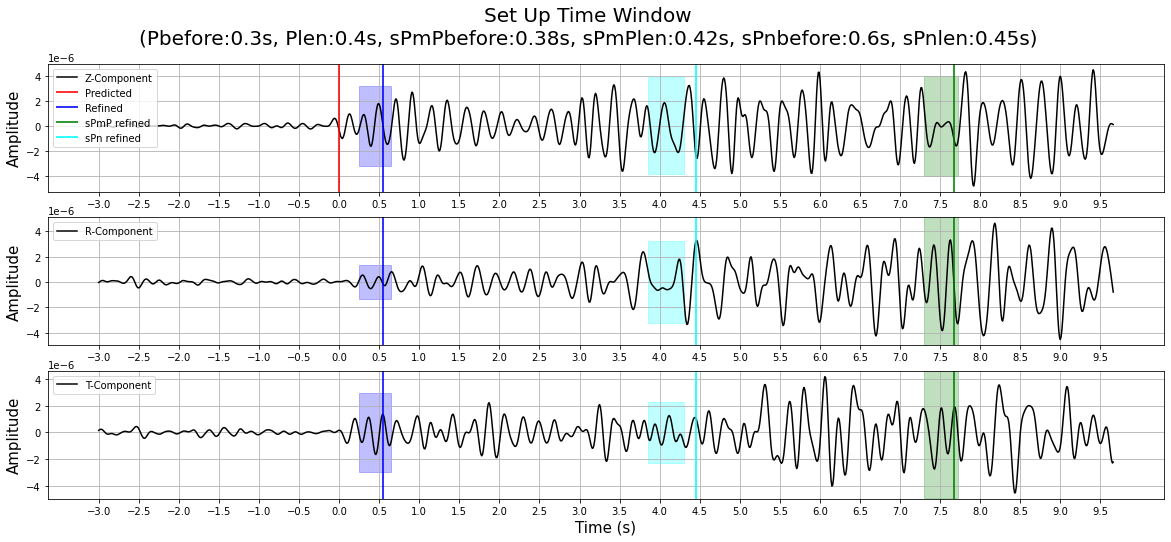

 Time Window Quality: y(good) or n(bad)y


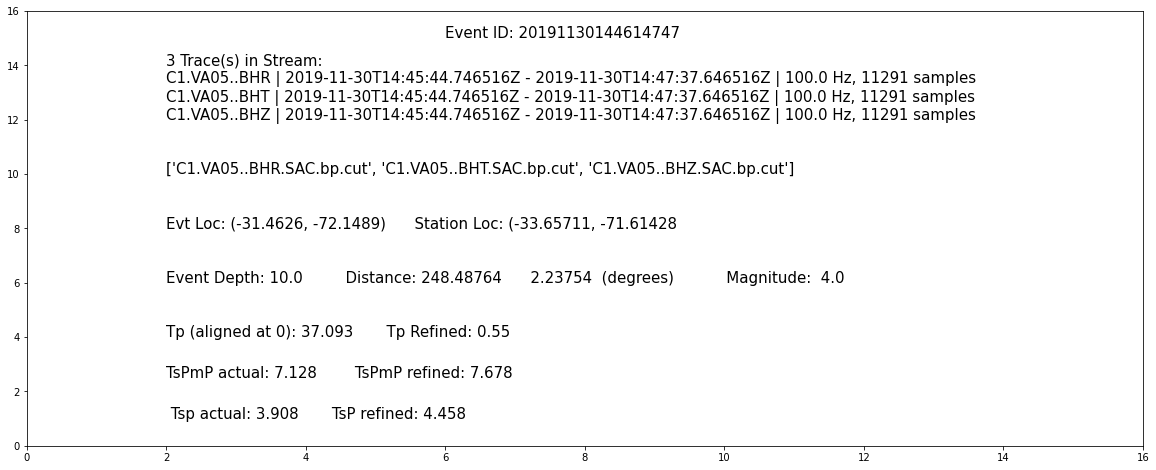

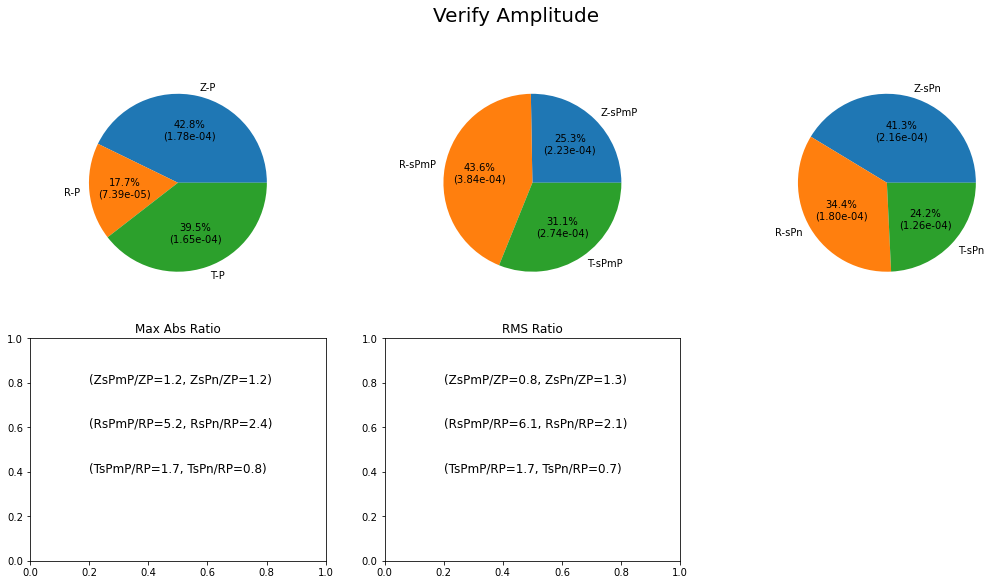

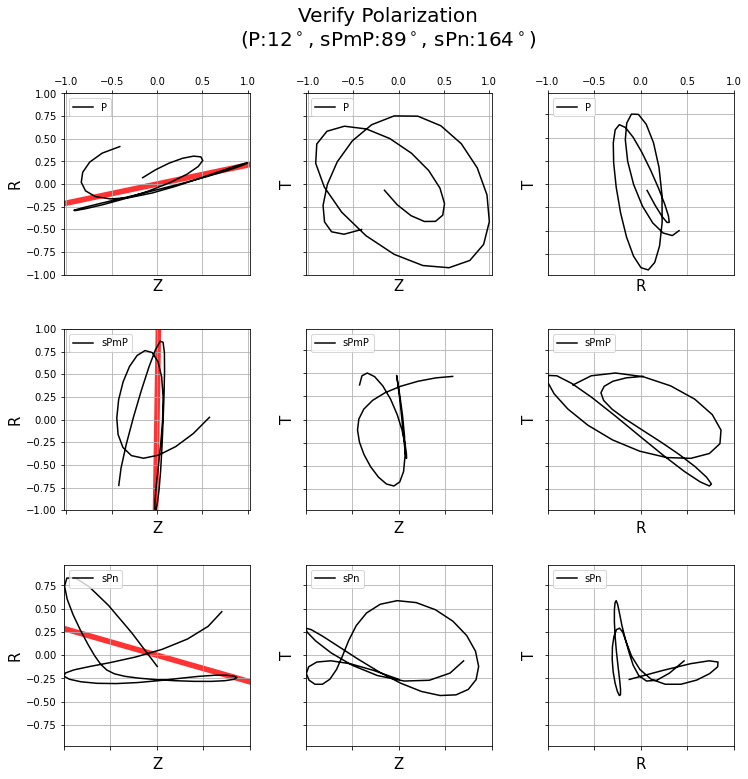

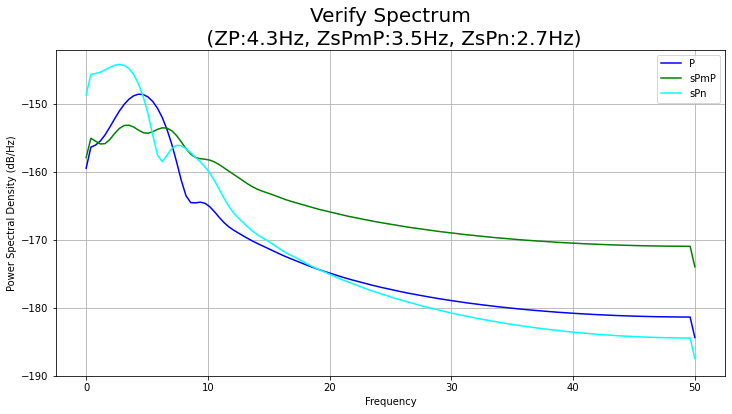

In [16]:
###### Check the event one by one
evtid = 1
for eve in os.listdir(wdir):
    evtid += len(os.listdir(f"{wdir}/{eve}"))

with open(f"{ddir}/Download/judge_good.info","r") as files:
    for i,file in enumerate(files):
        if i == evtid - 1:
            print(evtid)
            
            evtid+=1
            evt = file.split()[1]
            sta = file.split()[2]
            Tp = float(file.split()[4])
            TsPmP = float(file.split()[6])
            TsPn = float(file.split()[8])
            
            inpath = os.path.join(data_sac, evt)
            os.chdir(inpath)
            st = obspy.read(f"{sta}*[RTZ].SAC.bp.cut")
            sachd = st[0].stats.sac
            Tp1 = 0-st[0].stats.sac.o
            stations = glob.glob(f"{sta}*[RTZ].SAC.bp.cut")
            print(stations)
            print()
            print(st)
            print(sachd["evdp"],sachd["dist"])

        ### tune these parameters to set proper windows
            Tpbefore = 0.3
            Tplen = 0.4 
            Tspmbefore = 0.38
            Tspmlen = 0.42 
            Tspnbefore = 0.6
            Tspnlen = 0.45

            while 1:
                try:
                    print()
                    print("Tp: ", round(Tp1, 3), "\tTp refined: ", round(Tp-Tp1, 3), 
                      "\t  TsPmP refined (TsPmP-Tp ref): ", round(TsPmP-2*Tp1+Tp, 3), "\t  TsPn refined: ", round(TsPn-2*Tp1+Tp, 3))
                    print()

                    fig1 = set_window(st, Tp1, Tp, TsPmP, TsPn, Twbefore=3, Twafter=2, error_k=0, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
              
                except:
                    plt.clf()
                    print("Tp: ", round(Tp1, 3), "\tTp refined: ", round(Tp-Tp1, 3), 
                      "\t  TsPmP refined (TsPmP-Tp ref): ", round(TsPmP-2*Tp1+Tp, 3), "\t  TsPn refined: ", round(TsPn-2*Tp1+Tp, 3))
                    print()
                    fig1 = set_window(st, Tp1, Tp, TsPmP, TsPn, Twbefore=3, Twafter=2, error_k=1, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
                
                quality = input(" Time Window Quality: y(good) or n(bad)")
                time.sleep(1)
                if quality == "y":
                    
                    fig5 = get_info(st, sachd, evt, stations, Tp1, Tp-Tp1, TsPmP-2*Tp1+Tp, TsPn-2*Tp1+Tp)
                    fig2 = vef_amp(st, Tp1, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
                    fig3 = vef_polaz(st, Tp1, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
                    fig4 = vef_sptm(st, Tp1, Tp, TsPmP, TsPn, PN=2**8, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            
                    
                    if not os.path.exists(f"{wdir}/{evt}"):
                        os.mkdir(f"{wdir}/{evt}")
                    
                    pdf = PdfPages(f"{wdir}/{evt}/{sta}_analyses.pdf")
                    pdf.savefig(fig5)
                    pdf.savefig(fig1)
                    pdf.savefig(fig2)
                    pdf.savefig(fig3)
                    pdf.savefig(fig4)
                    pdf.close()
                    clear_output(wait=True)
                    break
                else:
                    #clear_output(wait=True)
                    print("\nRedecide the time window\n")
                    Tpbefore = float(input("Enter new Tp Before:  "))
                    Tplen = float(input("Enter new Tp Length:  "))
                    
                    Tspmbefore = float(input("\nEnter new TsPmP Before:  "))
                    Tspmlen = float(input("Enter new TsPmP Length:  "))
                    
                    Tspnbefore = float(input("\nEnter new TsPn Before:  "))
                    Tspnlen = float(input("Enter new TsPn Length:  "))
    
                    #break
                    #os.sys.exit()

            '''clear_output(wait=True)

            fig2 = vef_amp(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            fig3 = vef_polaz(st, plt.title('BHZ') Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            fig4 = vef_sptm(st, Tp, TsPmP, TsPn, PN=2**8, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            
            pdf = PdfPages(f"{wdir}/{sta}_analyses.pdf")
            pdf.savefig(fig1)
            pdf.savefig(fig2)
            pdf.savefig(fig3)
            pdf.savefig(fig4)
            pdf.close()'''
            